# Datenanalyse eines Rennspiels - Code Competition 2018-12

Der zur Verfügung gestellte Datensatz mit Einträgen zu Rennen in einem Spiel wird zuerst mit Hilfe von _pandas_ und _matplotlib_ aufbereitet, analysiert und visualisiert. Das Ziel soll sein, ein Modell mit _scikit-learn_ zu erstellen, das den Ausgang eines Rennens anhand der anderen Attribute vorhersagt.

Inhalt:
1. [Überblick über die Daten](#overview)
2. [Analyse der beendeten Rennen](#analysis)
3. [Entwicklung eines Vorhersage-Modells](#predict)

## 1. Überblick über die Daten <a name="overview"/>

Zu Beginn wird der gesamte Datensatz geladen und es werden, wenn nötig, Anpassungen am Format der Daten vorgenommen:

In [1]:
import pandas as pd
import numpy as np
from races_data_helpers import load_and_prepare_races
%matplotlib inline
import matplotlib.pyplot as plt

races = load_and_prepare_races()
races.head()

race_created         race_driven track_id  challenger  opponent  money  \
id                                                                          
1    2012-03-06 2012-06-03 00:00:00       12           5         2     30   
2    2012-03-06 2012-06-03 00:03:00       12           5         4     30   
3    2012-03-06                 NaT        3          10         5     30   
4    2012-03-06 2012-06-03 00:06:00       12           5         4     30   
5    2012-03-06                 NaT       12           4         5     30   

    fuel_consumption  winner    status  \
id                                       
1               0.63       5  finished   
2               0.63       4  finished   
3               0.63       0  declined   
4               0.63       5  finished   
5               0.63       0  declined   

                                             forecast weather  
id                                                             
1   {'sunny': 10, 'rainy': 70, 'thundery': 0, 'sno...   rainy  
2   {'sunny': 70, 'rainy': 15, 'thundery': 0, 'sno...   sunny  
3   {'sunny': 70, 'rainy': 10, 'thundery': 15, 'sn...     NaN  
4   {'sunny': 25, 'rainy': 75, 'thundery': 0, 'sno...   sunny  
5   {'sunny': 45, 'rainy': 20, 'thundery': 30, 'sn...     NaN

In [2]:
races.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166609 entries, 1 to 166609
Columns: 11 entries, race_created to weather
dtypes: category(3), datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 11.3+ MB


Insgesamt besteht der Datensatz also aus **166.609 Einträgen** mit je **11 Attributen**. Im Folgenden werden diverse interessante Eigenschaften näher betrachtet:

### 1.1 Wie viele Rennen wurden beendet?

Diese Frage ist bedutend für das Vorhersagemodell, das erstellt werden soll, da wir nur mit Einträgen zu beendeten Rennen arbeiten können.

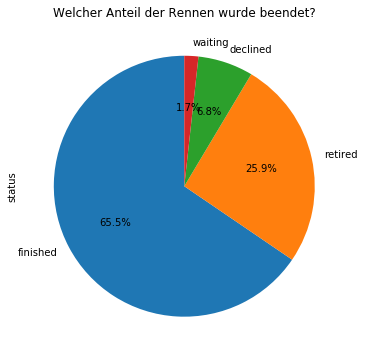

In [3]:
races["status"].value_counts().plot(kind='pie', startangle=90, autopct="%.1f%%", figsize=(6,6))
plt.title("Welcher Anteil der Rennen wurde beendet?")
plt.show()

Insgesamt wurde also knapp $\frac{2}{3}$ der Rennen beendet. Dies sind die Einträge, die [später](#predict) zur Erstellung des Modells verwendet werden.

### 1.2 Welche Strecken sind besonders beliebt?

Von den insgesamt zwölf verschiedenen Strecken sind einige ganz klar am beliebtesten, wie das folgende Diagramm zeigt. Die Strecken 12 und 3 stechen dabei klar hervor.

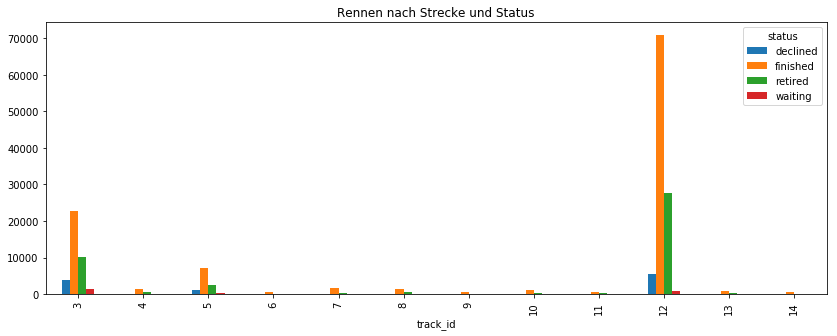

In [4]:
races_by_track = races.groupby(['track_id', 'status']).count().unstack()['race_created']
races_by_track.plot.bar(figsize=(14,5))
plt.title("Rennen nach Strecke und Status")
plt.show()

Im nächsten Diagramm zeigt sich nochmal deutlich die ungleiche Verteilung der Rennen auf die Strecken. Knapp **63% der Rennen** werden **auf Strecke 12** ausgetragen. Die drei beliebtesten Strecken sind Schauplatz von über 90% aller Rennen. 

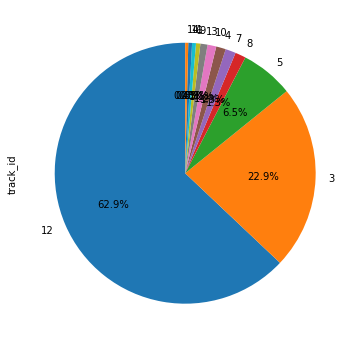

In [5]:
races['track_id'].value_counts().plot.pie(startangle=90, autopct="%.1f%%", figsize=(6,6))
plt.show()

Schließlich ist noch interessant, ob der Anteil der beendeten Rennen zwischen den Strecken unterschiedlich ist. Es zeigt sich, dass z.B. auf Strecke 14 über $\frac{3}{4}$ der Rennen beendet werden, wohingegen aus etwa auf Strecke 3 nur knapp 60% sind.

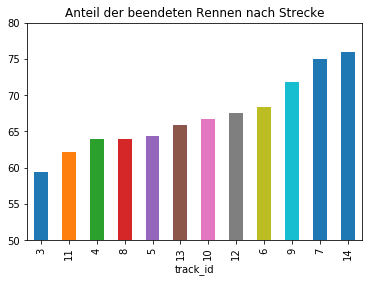

In [6]:
races_by_track.apply(lambda x: x / x.sum() * 100, axis=1)['finished'].sort_values().plot.bar(ylim=(50,80))
plt.title("Anteil der beendeten Rennen nach Strecke")
plt.show()

### 1.3 Wann wurden bevorzugt Rennen ausgetragen?

Zuerst ist die Zahl der Rennen im Verlauf der Jahre sehr auffällig. Diese nimmt vom ersten erfassten Jahr 2012 bis 2017 exponentiell ab. Während im ersten Jahr noch fast 70.000 Rennen gefahren werden, sind es 2017 im gesamten Jahr nur noch unter 200.

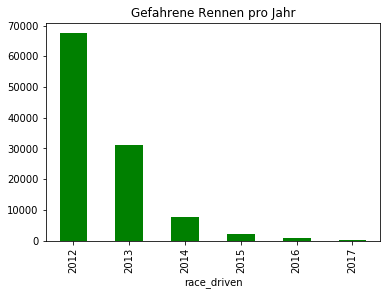

In [7]:
races.set_index('race_driven').resample('1y').size().plot.bar(color='g')
plt.title("Gefahrene Rennen pro Jahr")
plt.xticks(range(6), ['2012', '2013', '2014', '2015', '2016', '2017'])
plt.show()

Noch deutlicher zeigt sich dieser Trend im Monatsverlauf:

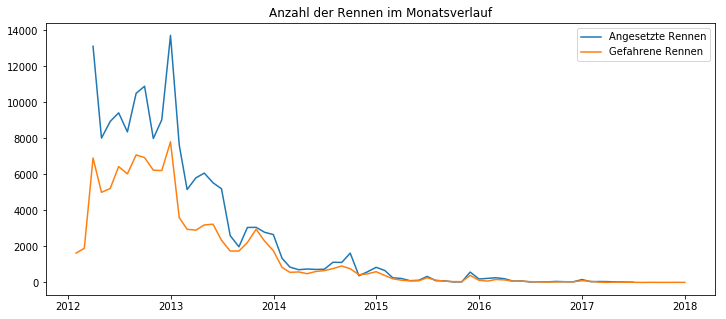

In [8]:
plt.figure(figsize=(12,5))
plt.plot(races.set_index('race_created').resample('1m').size(), label='Angesetzte Rennen')
plt.plot(races.set_index('race_driven').resample('1m').size(), label='Gefahrene Rennen')
plt.title("Anzahl der Rennen im Monatsverlauf")
plt.legend()
plt.show()

Interessant sind auch die Tageszeiten, zu dennen Rennen bevorzugt stattfinden. Deutlich hervor stechen im Tagesverlauf (linkes Diagramm unten) die **Abendstunden** (v.a. 20 - 21 Uhr), sowie die **Mittagszeit** (13 - 14 Uhr). Die wenigsten Rennen finden in den frühen Morgenstunden statt.

Im Verlauf der Woche (rechts) zeigen sich dagegen keine signifikanten Unterschiede, lediglich der Sonntag sticht leicht heraus.

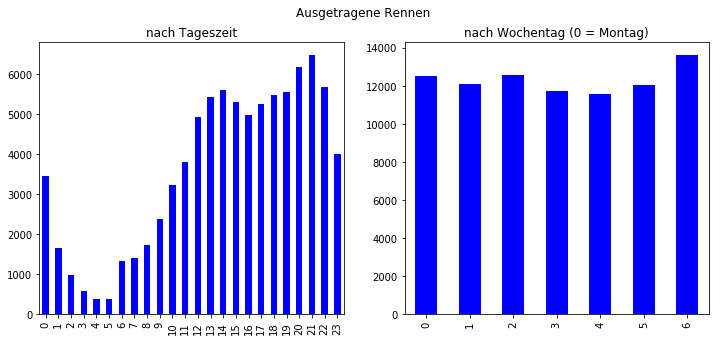

In [9]:
races_by_date = races.dropna(subset=['race_driven']).groupby('race_driven').size()
fig, axs = plt.subplots(1, 2, figsize=(12,5))
races_by_date.groupby(lambda x: x.hour).size().plot.bar(ax=axs[0], color='b', title="nach Tageszeit")
races_by_date.groupby(lambda x: x.dayofweek).size().plot.bar(ax=axs[1], color='b', title="nach Wochentag (0 = Montag)")
plt.suptitle("Ausgetragene Rennen")
plt.show()

### 1.4 Wie hoch sind die Renneinsätze?

Interessant sind auch die Einsätze für die Rennen, da sich auch hier schon im Überblick eine sehr breite Spanne zeigt, wobei sich der Großteil der Einsätze am unteren Ende sammelt. (Zu beachten ist, dass das Diagramm bei einer Gewinnsumme von 10.000€ gekappt wurde.)

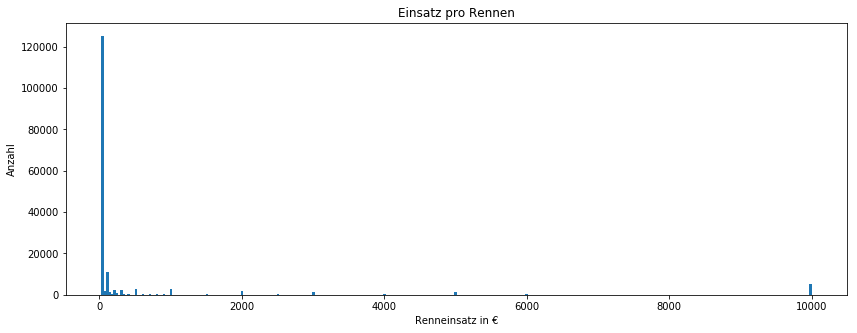

In [10]:
races['money'].where(races['money'] < 10000, 10000).plot.hist(bins=300, figsize=(14,5))
plt.title("Einsatz pro Rennen")
plt.xlabel("Renneinsatz in €")
plt.ylabel("Anzahl")
plt.show()

In der genaueren Analyse zeigt sich, dass der am häufigsten gesetzte Betrag auch der Minimalbetrag ist (30 €). Durchschnittlich werden ca. 2400 € pro Rennen gesetzt.

In [11]:
from races_data_helpers import print_stat_values

print_stat_values(races['money'], text="Angesetzte Rennen (Einsatz)")
print_stat_values(races[races['status'] == 'finished']['money'], text="Beendete Rennen (Einsatz)")

--- Angesetzte Rennen (Einsatz) ---
Anzahl:  166609
Minimum:  30
Maximum:  2400000
Durchschnitt: 2401.86
Median: 30.00
Modus: 30.00
--- Beendete Rennen (Einsatz) ---
Anzahl:  109099
Minimum:  30
Maximum:  2044875
Durchschnitt: 2187.44
Median: 30.00
Modus: 30.00


Bemerkenswert ist noch der Unterschied der Werte zwischen _allen_ Rennen (angesetzte Rennen) und den tatsächlich _beendeten_ Rennen, da bei letzteren der Schnitt und der Median deutlich niedriger sind.

Beispielhaft zeigt sich das in folgender Tabelle, sie zeigt die fünf Rennen mit dem höchsten Renneinsatz. Nur eines dieser Rennen wurde tatsächlich beendet.

In [12]:
races[['race_created', 'race_driven', 'money', 'status']].sort_values(by='money', ascending=False).head()

race_created         race_driven    money    status
id                                                       
85670   2012-11-28                 NaT  2400000   retired
98019   2012-12-23                 NaT  2216093   retired
89783   2012-12-10                 NaT  2059081   retired
89636   2012-12-09 2012-09-12 22:25:00  2044875  finished
89611   2012-12-09                 NaT  2000000   retired

Nun lässt sich noch überprüfen, ob der mittlere Renneinsatz an bestimmten Strecken höher ist. Tatsächlich zeigen sich auch hier Unterschiede:

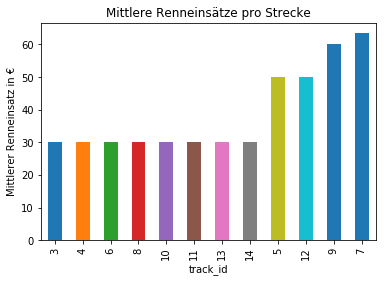

In [13]:
races.groupby('track_id').median()['money'].sort_values().plot.bar()
plt.title("Mittlere Renneinsätze pro Strecke")
plt.ylabel("Mittlerer Renneinsatz in €")
plt.show()

### 1.5 Wie entwickelt sich der Spritverbrauch?

Zum Schluss noch ein kurzer Blick auf die Entwicklung Kraftstoffverbräuche. Der absolute Jahresverbrauch (rechts) nimmt natürlich mit der Anzahl der gefahrenen Rennen ab.

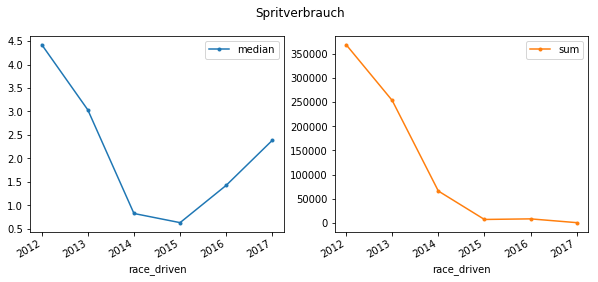

In [14]:
fuel_consumptions = races.set_index('race_driven').resample('1y').agg(['median', 'sum'])['fuel_consumption']
fuel_consumptions.plot(subplots=True, layout=(1,2), figsize=(10,4), style=".-")
plt.suptitle("Spritverbrauch")
plt.show()

## 2. Analyse der beendeten Rennen <a name="analysis"/>

### 2.1 Datensatz filtern

Nachdem nun diverse Eigenschaften betrachtet wurden, beschränken wir uns im folgenden auf die _beendeten Rennen_ und einige Haupt-Eigenschaften, von denen der Rennsieg abhängen könnte. Zudem werden zwei neue Eigenschaften hinzugefügt.

In [15]:
from races_data_helpers import remove_unfinished, add_forecast_correctness, add_winner_bool

races_prep = races.copy()
# Entferne nicht beendete Rennen
races_prep = remove_unfinished(races_prep)
# Faktor für Richtigkeit der Wettervorhersage
races_prep = add_forecast_correctness(races_prep)
# Hat der Herausforderer gewonnen?
races_prep = add_winner_bool(races_prep)
races_prep.drop(["race_created", "race_driven", "fuel_consumption", "forecast"], inplace=True, axis=1)
races_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109099 entries, 1 to 166608
Data columns (total 8 columns):
track_id                109099 non-null category
challenger              109099 non-null int64
opponent                109099 non-null int64
money                   109099 non-null int64
winner                  109099 non-null int64
weather                 109099 non-null category
forecast_correctness    109099 non-null float64
challenger_won          109099 non-null bool
dtypes: bool(1), category(2), float64(1), int64(4)
memory usage: 5.3 MB


Der modifizierte Datensatz hat nun folgende Form:

In [16]:
races_prep.head()

track_id  challenger  opponent  money  winner weather  \
id                                                         
1        12           5         2     30       5   rainy   
2        12           5         4     30       4   sunny   
4        12           5         4     30       5   sunny   
6        12           5        10    100       5   snowy   
9         3          10         4     30       4   sunny   

    forecast_correctness  challenger_won  
id                                        
1                   0.70            True  
2                   0.70           False  
4                   0.25            True  
6                   0.45            True  
9                   0.45           False

### 2.2 Hat der Herausforderer gewonnen?

Eine der neu hinzugefügten Attribute ist ein Wahrheitswert, der angibt, ob der Herausforderer das Rennen gewonnen hat. Dieses Attribut ersetzt (in Kürze) die Spalte mit der numerischen Angabe des Gewinners und ist das Hauptmerkmal, mit dem wir uns im folgenden beschäftigen, da es später **die Zielgröße des Vorhersagemodells** werden soll.

Zuerst ein Überblick, wie häufig der Herausforderer gewonnen hat:

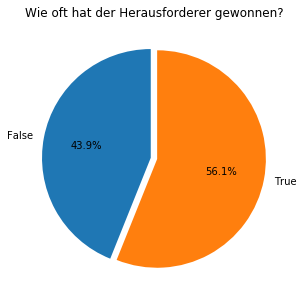

In [17]:
from races_data_helpers import plot_challenger_won

fig, ax = plt.subplots(figsize=(5,5))
plot_challenger_won(ax, races_prep)
plt.ylabel(None)
plt.show()

### 2.3 Welchen Einfluss hat die Erfahrung der Fahrer?

In folgendem Diagramm zeigt sich, dass die Anzahl der Rennen, die die **insgesamt 5749 Fahrer** beendet haben, sehr unterschiedlich ist:

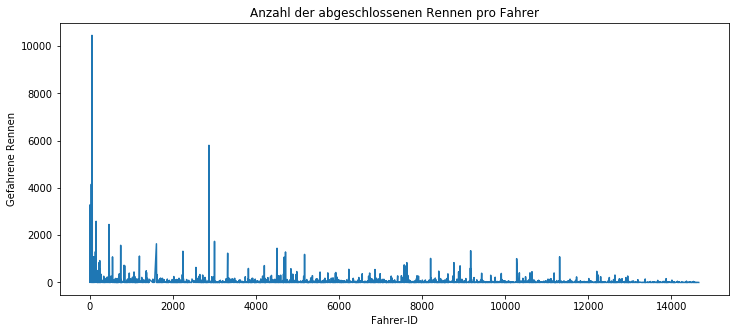

In [18]:
from races_data_helpers import get_race_counts

race_counts = get_race_counts(races_prep)
race_counts.plot(figsize=(12,5))
plt.title("Anzahl der abgeschlossenen Rennen pro Fahrer")
plt.xlabel("Fahrer-ID")
plt.ylabel("Gefahrene Rennen")
plt.show()

Der Fahrer mit den meisten beendeten Rennen (Fahrer 48) ist über 10.000 Rennen gefahren, fast doppelt so viele wie der Fahrer mit den zweitmeisten Rennen. Durchschnittlich ist ein Fahrer knapp 38 Rennen gefahren.

In [19]:
print_stat_values(race_counts)

--- Statistische Werte ---
Anzahl:  5749
Minimum:  1.0
Maximum:  10461.0
Durchschnitt: 37.95
Median: 6.00
Modus: 1.00


Hier die fünf Fahrer mit den meisten Rennen:

In [20]:
race_counts.sort_values(ascending=False).head()

48      10461.0
2866     5806.0
46       5049.0
32       4159.0
55       3858.0
dtype: float64

An der Statistik lässt sich aber auch erkennen, dass viele Fahrer nur eine geringe Zahl an Rennen gefahren ist. Deutlich wird das nochmal in folgendem Diagramm, dass die Fahrer nach gefahrenen Rennen ordnet. Wie sich zeigt sind viele Fahrer nur 1 Rennen zu Ende gefahren.

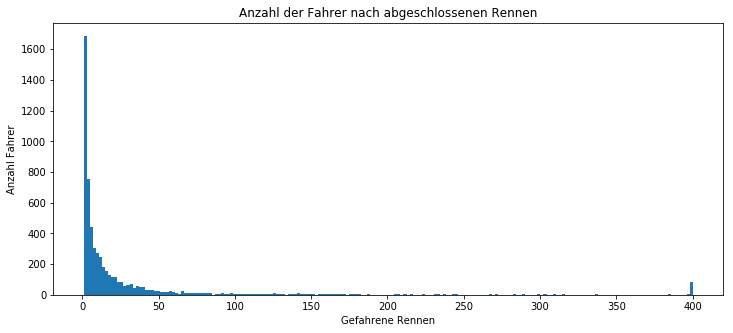

In [21]:
plt.title("Anzahl der Fahrer nach abgeschlossenen Rennen")
hist_counts = race_counts.where(race_counts < 400, 400)
hist_counts.plot.hist(bins=200, figsize=(12,5))
plt.xlabel("Gefahrene Rennen")
plt.ylabel("Anzahl Fahrer")
plt.show()

Es stellt sich die Frage, ob die Anzahl der gefahrenen Rennen (also die Erfahrung) einen Einfluss auf die Siegchancen eines Fahrers hat. Dazu berechnen wir für jedes Rennen das Verhältnis aus gefahrenen Rennen zwischen Herausforderer und Gegner (`exp_ratio` genannt), um ein Maß für das Verhältnis der Erfahrungen zu bekommen. Dies geschieht wie folgt:

In [22]:
experience_ratios = races_prep.apply(lambda x: race_counts[x['challenger']] / race_counts[x['opponent']], axis=1)
experience_df = pd.concat([experience_ratios.rename('exp_ratio'), races_prep['challenger_won']], axis=1)
experience_df.head()

exp_ratio  challenger_won
id                             
1   3290.000000            True
2    156.666667           False
4    156.666667            True
6    117.500000            True
9      1.333333           False

Im folgenden gegenübergestellt sind dieses Erfahrungsverhältnis und die Gewinnwahrscheinlichkeit des Herausforderers. Deutlich erkennbar ist, dass ein **erfahrener Herausforderer häufiger gewinnt**.

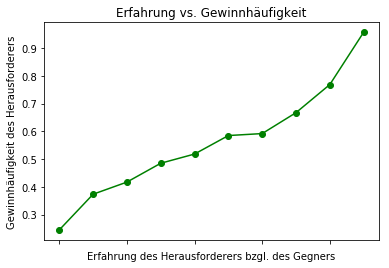

In [23]:
bins = pd.qcut(experience_df['exp_ratio'], 10)
experience_vs_won = experience_df.groupby(bins).agg(['count', 'mean', 'std'])['challenger_won']
plt.title("Erfahrung vs. Gewinnhäufigkeit")
experience_vs_won['mean'].plot(style='go-')
plt.xlabel('Erfahrung des Herausforderers bzgl. des Gegners')
plt.ylabel('Gewinnhäufigkeit des Herausforderers')
plt.show()

Auch in folgender Darstellung zeigt sich dieser Trend. Ist der Herausforderer erfahrener als sein Gegner, so gewinnt er häufiger als wenn der Gegner erfahrener ist:

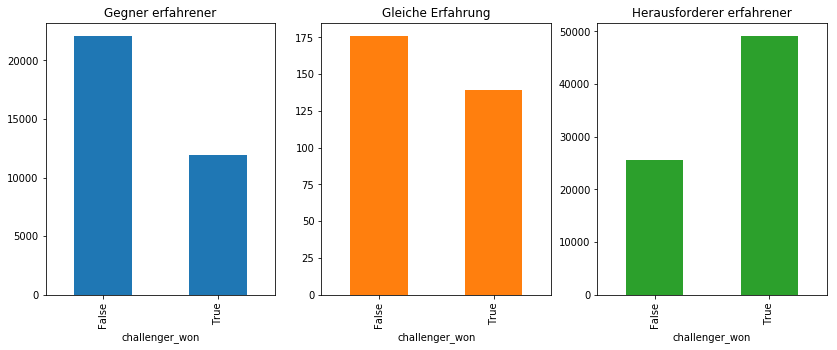

In [24]:
from races_data_helpers import split_experiences
    
split = split_experiences(experience_df)
split.plot.bar(subplots=True, layout=(1,3), figsize=(14,5), legend=False,
              title=["Gegner erfahrener", "Gleiche Erfahrung", "Herausforderer erfahrener"])
plt.show()

Allerdings lässt sich daraus nicht schließen, dass Fahrer mit mehr Rennen generell eine höhere Gewinnquote haben, wie folgendes Diagramm veranschaulicht:

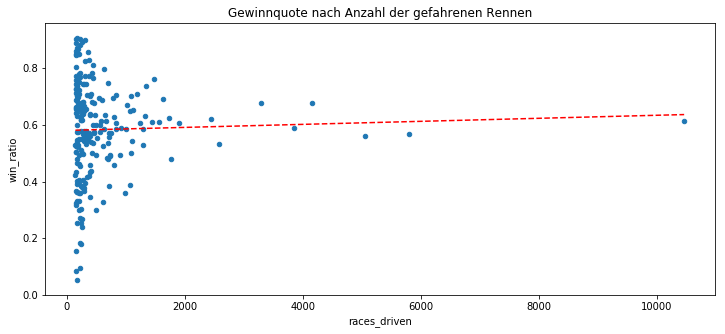

In [25]:
min=150
max=np.max(race_counts)

win_ratios = races_prep.groupby('winner').size() / race_counts
driven_vs_won = pd.concat([race_counts.rename('races_driven'), win_ratios.rename('win_ratio')], axis=1).fillna(0)
driven_vs_won = driven_vs_won[driven_vs_won['races_driven'] > min]
driven_vs_won.plot.scatter(x='races_driven', y='win_ratio', figsize=(12,5))
fit = np.polyfit(driven_vs_won['races_driven'], driven_vs_won['win_ratio'], 1)
fit_func = np.poly1d(fit)
x = np.linspace(min, max, 200)
plt.plot(x, fit_func(x), 'r--')
plt.title("Gewinnquote nach Anzahl der gefahrenen Rennen")
plt.show()

### 2.4 Welchen Einfluss hat das Wetter?

Auch das Wetter kann einen Einfluss auf den Rennausgang haben. Dazu betrachten wir zuerst, wie häufig welches Wetter auftritt:

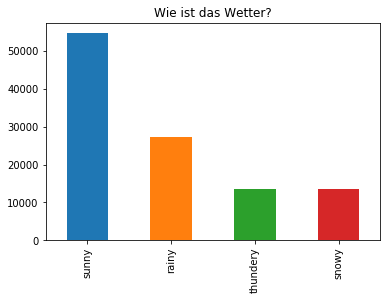

In [26]:
plt.title("Wie ist das Wetter?")
races_prep["weather"].value_counts().plot(kind='bar')
plt.show()

Da im Datensatz eine detaillerte Wettervorhersage für jedes Rennen enthalten ist, stellt sich auch die Frage, wie exakt diese Vorhersage ist. Dazu sind folgend die Wahrscheinlichkeiten dargestellt, mit denen das tatsächlich zutreffende Wetter vorhergesagt wurde:

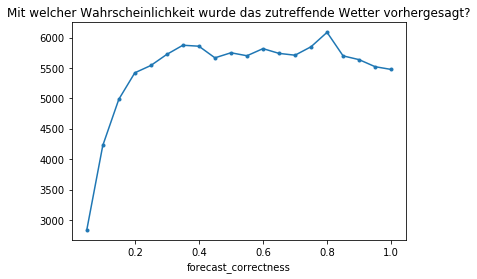

In [27]:
plt.title("Mit welcher Wahrscheinlichkeit wurde das zutreffende Wetter vorhergesagt?")
races_prep.groupby("forecast_correctness").size().plot(style='.-')
plt.show()

Es stellt sich heraus, dass das zutreffende Wetter in etwa gleich häufig mit 100% Wahrscheinlichkeit wie auch mit 20% Wahrscheinlichkeit vorhergesagt wurde. Am zutreffendsten ist die Vorhersage im Schnitt bei sonnigem Wetter, wie sich unten links zeigt.

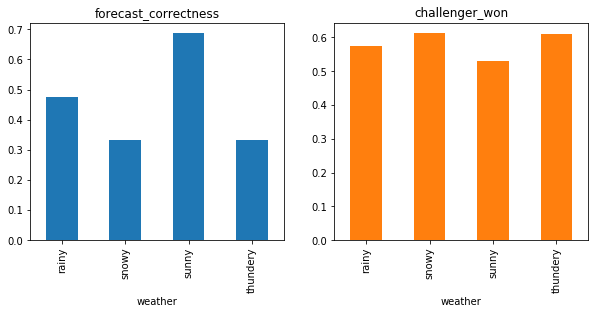

In [28]:
weather_df = races_prep.groupby('weather')['forecast_correctness', 'challenger_won'].mean()
weather_df.plot.bar(subplots=True, layout=(1,2), figsize=(10,4), legend=False)
plt.show()

Das tatsächliche Wetter hat keinen bedeutenden Einfluss auf die Siegchancen des Herausforderers (oben rechts), aber es scheint so, dass der Herausforderer davon profitiert, dass die Wettervorhersage falsch liegt:

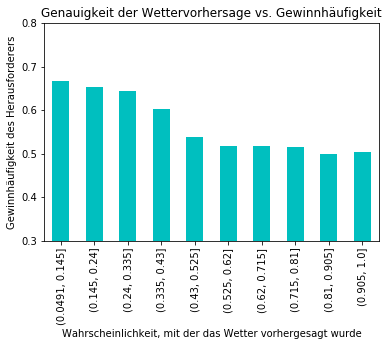

In [29]:
bins = pd.cut(races_prep['forecast_correctness'], 10)
races_prep.groupby(bins).mean()['challenger_won'].plot(kind='bar', ylim=(0.3,0.8), color='c')
plt.title('Genauigkeit der Wettervorhersage vs. Gewinnhäufigkeit')
plt.ylabel('Gewinnhäufigkeit des Herausforderers')
plt.xlabel('Wahrscheinlichkeit, mit der das Wetter vorhergesagt wurde')
plt.show()

Dieser Zusammenhang zeigt sich auch in der direkten Gegenüberstellung der Rennen mit einer guten Wettervorhersage (mit > 50% Wahrscheinlichkeit korrekt vorhergesagt) und einer schlechteren Vorhersage (< 50%):

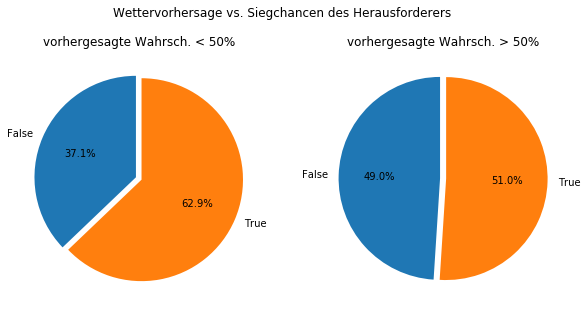

In [30]:
forecasts_low = races_prep[races_prep['forecast_correctness'] < 0.5]
forecasts_high = races_prep[races_prep['forecast_correctness'] > 0.5]
fig, axs = plt.subplots(1, 2, figsize=(10,5))
plot_challenger_won(axs[0], forecasts_low, title='vorhergesagte Wahrsch. < 50%')
plot_challenger_won(axs[1], forecasts_high, title='vorhergesagte Wahrsch. > 50%')
plt.suptitle("Wettervorhersage vs. Siegchancen des Herausforderers")
plt.show()

### 2.5 Renneinsatz

Am Ende ist noch anzumerken, dass der Renneinsatz keinen merklichen Einfluss auf den Sieg des Herausforderers hat.

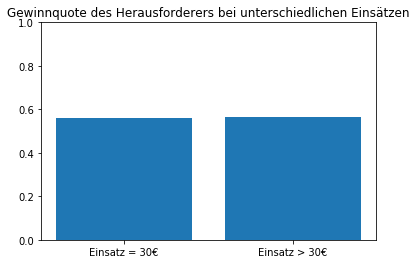

In [31]:
money_l_quote = races_prep[races_prep['money'] == 30]['challenger_won'].mean()
money_h_quote = races_prep[races_prep['money'] > 30]['challenger_won'].mean()
plt.title("Gewinnquote des Herausforderers bei unterschiedlichen Einsätzen")
plt.bar(range(2), [money_l_quote, money_h_quote])
plt.xticks(range(2), ["Einsatz = 30€", "Einsatz > 30€"])
plt.ylim((0, 1))
plt.show()

## 3. Entwicklung eines Vorhersage-Modells <a name="predict"/>

### 3.1 Daten vorbereiten und Modell trainieren

Da sich im vorigen Abschnitt herausgestellt hat, dass der Rennsieg durchaus von verschiedenen Faktoren abhängig zu sein scheint, lohnt es sich, zu versuchen, ein Vorhersagemodell zu entwickeln. Zu diesem Zweck werden zu Beginn die vielversprechendsten Attribute ausgewählt und im nächsten Schritt der Datensatz in einen Trainingsdatensatz zur Erstellung des Modells und einen Testdatensatz zur späteren Überprüfung aufgeteilt. Zudem wird die vorherzusagende Zielgröße ("Hat der Herausforderer gewonnen?") vom Rest des Datensatzes getrennt. 

In [32]:
from sklearn.model_selection import train_test_split

races_in = races_prep[["track_id", "challenger", "opponent", "weather", "forecast_correctness"]]
races_out = races_prep["challenger_won"]

X_train, X_test, y_train, y_test = train_test_split(races_in, races_out, test_size=0.2, random_state=27)

Nun werden die Eingabegrößen für das Vorhersagemodell vorbereitet. In diesem Fall ist der Anteil der kategorischen Eingabedaten sehr hoch. Alle diese Eingaben werden mit Hilfe eines von scikit-learn zur Verfügung gestellten Encoders in One-Hot-Kodierung transformiert. Lediglich die Richtigkeit der Wettervorhersage ist numerisch und bereits passend skaliert.

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

pre_transform = ColumnTransformer([
    ('categories', OneHotEncoder(handle_unknown='ignore'), ['track_id', 'challenger', 'opponent', 'weather']),
    ('numbers', 'passthrough', ['forecast_correctness'])
])

X_trans = pre_transform.fit_transform(X_train)
X_trans.shape

(87279, 8389)

Nun muss ein passendes Vorhersagemodell gewählt werden. Bei vorliegendem Problem handelt es sich um eine typische Aufgabe binärer Klassifikation. Die Wahl fällt auf einen binären Klasifikator mit **logistischer Regression**, da dieser ein relativ einfaches (lineares) Modell liefert und auf der Größe des Datensatzes genügend schnell läuft.

Um zu überprüfen, ob der trainierte Klassifikator tatsächlich relevante Ergebnisse erzielt, wird er mit einem "Dummy"-Klassifikator verglichen, der Rennergebnisse zufällig (nach Häufigkeit im Trainingsdatensatz) vorhersagt.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

print("Accuracies:")
first_clf = LogisticRegression(solver="liblinear", random_state=12)
first_clf.fit(X_trans, y_train)
print("Logistic: ", first_clf.score(X_trans, y_train))

dummy = DummyClassifier(random_state=12)
dummy.fit(X_trans, y_train)
print("Dummy: ", dummy.score(X_trans, y_train))

Accuracies:
Logistic:  0.7783200999094857
Dummy:  0.5070062672578741


Auf den ersten Blick scheint der trainierte Klassifikator deutlich bessere Ergebnisse zu erzielen als der zufällige Klassifikator. Mittels Kreuzvalidierung auf dem Testdatensatz werden aussagekräftigere Genauigkeitsquoten sowie Precision und Recall berechnet:

In [35]:
from sklearn.model_selection import cross_val_predict
from races_data_helpers import print_metrics, plot_confusion_matrix

y_train_pred_log = cross_val_predict(first_clf, X_trans, y_train, cv=3)
print_metrics(y_train, y_train_pred_log, "Logistic Regression")

y_train_pred_dummy = cross_val_predict(dummy, X_trans, y_train, cv=3)
print_metrics(y_train, y_train_pred_dummy, "Dummy")

--- Logistic Regression ---
Accuracy:   0.7474764834610845
Precision:  0.766043995102879
Recall:     0.7919405544441269
Confusion matrix: 
[[26445 11848]
 [10192 38794]]
--- Dummy ---
Accuracy:   0.507636430298239
Precision:  0.5614060170339658
Recall:     0.5611195035316213
Confusion matrix: 
[[16819 21474]
 [21499 27487]]


Der Klassifikator sagt etwa 75% der Rennergebnisse richtig voraus. Das ist zwar nicht perfekt, aber dennoch deutlich besser als eine zufällige Vorhersage. Im folgenden sind die Konfusionsmatrizen des Klassifikators und des Dummies visualisiert.

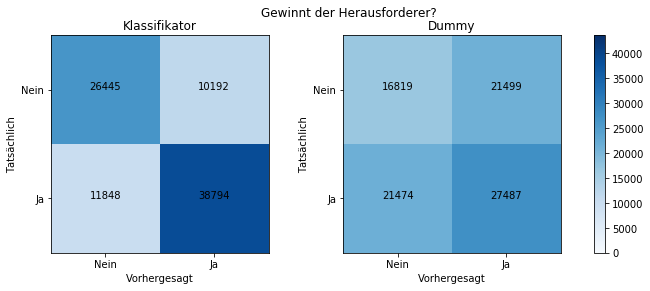

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

im1 = plot_confusion_matrix(axs[0], "Klassifikator", y_train, y_train_pred_log)
im2 = plot_confusion_matrix(axs[1], "Dummy", y_train, y_train_pred_dummy)

fig.colorbar(im2, ax=axs.ravel().tolist())
plt.suptitle("Gewinnt der Herausforderer?")
plt.show()

### 3.2 Modell optimieren

Schließlich kann über die Veränderung der Hyperparameter des Klassifikators noch versucht werden, die Genauigkeit weiter zu steigern. Die Gittersuche liefert aber nur ein geringfügig verbessertes Modell.

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.01, 0.1, 1, 10, 20, 50, 100, 1000]}

grid_search = GridSearchCV(first_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_trans, y_train)

pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.151434      0.001931         0.002668    4.563669e-04    0.01   
1       0.253093      0.013353         0.002660    4.706966e-04     0.1   
2       0.503335      0.016248         0.003306    4.619551e-04       1   
3       0.975161      0.081179         0.002660    4.704151e-04      10   
4       1.091653      0.053046         0.002327    4.700781e-04      20   
5       1.598771      0.205535         0.002992    2.247832e-07      50   
6       1.542399      0.008041         0.002969    1.903205e-05     100   
7       4.779807      0.325152         0.002991    1.808772e-06    1000   

        params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 0.01}           0.659896           0.664833           0.654407   
1   {'C': 0.1}           0.723517           0.724951           0.716726   
2     {'C': 1}           0.750258           0.748874           0.743297   
3    {'C': 10}           0.752561           0.755577           0.749244   
4    {'C': 20}           0.753523           0.755130           0.749106   
5    {'C': 50}           0.753282           0.754030           0.748866   
6   {'C': 100}           0.753007           0.753583           0.749072   
7  {'C': 1000}           0.753248           0.753171           0.748488   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.659712        0.004259                8            0.665120   
1         0.721731        0.003587                7            0.739813   
2         0.747476        0.003009                6            0.780699   
3         0.752461        0.002586                2            0.794930   
4         0.752587        0.002547                1            0.795944   
5         0.752059        0.002279                3            0.797164   
6         0.751888        0.002005                4            0.797439   
7         0.751636        0.002226                5            0.797542   

   split1_train_score  split2_train_score  mean_train_score  std_train_score  
0            0.664541            0.667142          0.665601         0.001115  
1            0.737377            0.741059          0.739416         0.001529  
2            0.779174            0.782133          0.780669         0.001209  
3            0.794384            0.796432          0.795249         0.000866  
4            0.795827            0.797343          0.796371         0.000689  
5            0.795844            0.797738          0.796916         0.000793  
6            0.795724            0.797824          0.796996         0.000913  
7            0.795930            0.797652          0.797042         0.000787

### 3.3 Finaler Test

Der beste gefundene Klassifikator wird nun auf dem zurückgestellten Testdatensatz gestestet. Auch hier erzielt er etwa eine Genauigkeit von 75%.

In [38]:
best_clf = grid_search.best_estimator_

X_test_trans = pre_transform.transform(X_test)

y_predicted = best_clf.predict(X_test_trans)

print_metrics(y_test, y_predicted, "Final Test")

--- Final Test ---
Accuracy:   0.7566911090742439
Precision:  0.7838528781131453
Recall:     0.7795456409415238
Confusion matrix: 
[[7006 2621]
 [2688 9505]]


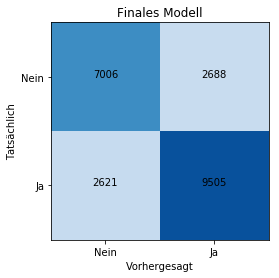

In [39]:
fig, ax = plt.subplots()
plot_confusion_matrix(ax, "Finales Modell", y_test, y_predicted)
plt.show()

Die Qualität des Klassifikators kann auch mit einer ROC-Kurve beurteilt werden, die die Richtig-Positiv-Rate gegen die Falsch-Positiv-Rate plottet. Auch hier zeigt sich, dass das trainierte Klassifikator (in blau) deutlich besser als der zufällige (in rot) abschneidet.

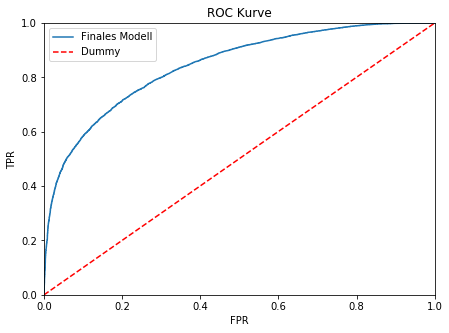

In [40]:
from races_data_helpers import plot_roc_curve

fig, ax = plt.subplots(figsize=(7,5))
plot_roc_curve(ax, best_clf, y_test, X_test_trans, label='Finales Modell')
plot_roc_curve(ax, dummy, y_test, X_test_trans, style='r--', label="Dummy")
plt.title("ROC Kurve")
plt.legend()
plt.show()

Zum Schluss ist noch interessant, ob sich in den Vorhersagen des Klassifikators eine Tendenz erkennen lässt. Dazu plotten wir die Vorhersagen in ein Diagramm, das die gefahrenen Rennen des Herausforderers und seines Gegners gegenüberstellt. Tendenziell ist erkennbar, dass das Modell eher vorhersagt, dass der Herausforderer gewinnt (blau), wenn er einen Erfahrungsvorteil gegenüber seinem Gegner hat (unten rechts).

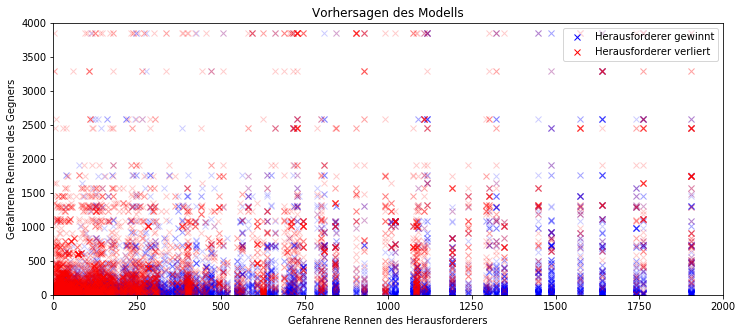

In [41]:
def driver_race_counts(df, counts):
    new_df = df[['challenger', 'opponent']].copy()
    new_df = new_df.applymap(lambda x: counts[x])
    return new_df

fig, ax = plt.subplots(figsize=(12,5))
ax.axis([0, 2000, 0, 4000])
pred_df = driver_race_counts(X_test, race_counts)
pred_df["predicted"] = y_predicted
# Plot the data points
pred_df[pred_df['predicted'] == True].plot(ax=ax, x='challenger', y='opponent', style='bx', alpha=0.2)
pred_df[pred_df['predicted'] == False].plot(ax=ax, x='challenger', y='opponent', style='rx', alpha=0.2)
# Add some description to the plot
plt.title('Vorhersagen des Modells')
leg = plt.legend(['Herausforderer gewinnt', 'Herausforderer verliert'], loc=1)
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
plt.xlabel('Gefahrene Rennen des Herausforderers')
plt.ylabel('Gefahrene Rennen des Gegners')
plt.show()

Für die Wiederverwendung wird das trainierte Modell abgespeichert. Das Modell kann z.B. über das beiliegende Skript `predict.py` genutzt werden, um den Sieger von zukünftigen Rennen vorherzusagen.

In [42]:
from sklearn.externals import joblib

joblib.dump((pre_transform, best_clf), "model/race_classifier.pkl")

['model/race_classifier.pkl']